[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Images with Segment Anything 2 (SAM2)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything-2)

This notebook is an extension of the official [notebook](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb) prepared by Meta AI.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jul 30 06:51:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model 2 (SAM2)

In [3]:
# !pip install -q 'git+https://github.com/facebookresearch/segment-anything-2.git'

!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 285 (delta 2), reused 1 (delta 1), pack-reused 279
Receiving objects: 100% (285/285), 42.91 MiB | 10.57 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 147.1 kB/s eta 0:00:00
  Building editable f

In [40]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00


### Download SAM2 checkpoints

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

## Load Model

In [28]:
import torch

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

In [29]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

## Automated Mask Generation

In [30]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [31]:
import cv2
import supervision as sv

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [32]:
sam2_result[0]

{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 235358,
 'bbox': [0.0, 0.0, 719.0, 648.0],
 'predicted_iou': 0.9921875,
 'point_coords': [[11.25, 20.0]],
 'stability_score': 0.9773262739181519,
 'crop_box': [0.0, 0.0, 720.0, 1280.0]}

### Results visualisation with Supervision

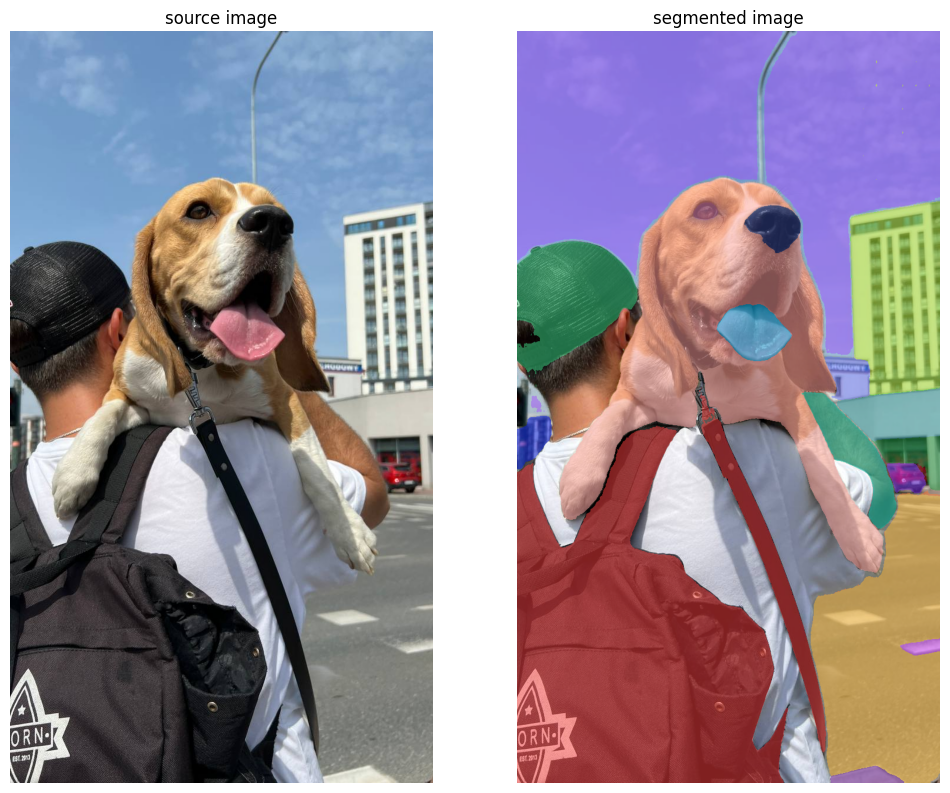

In [33]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

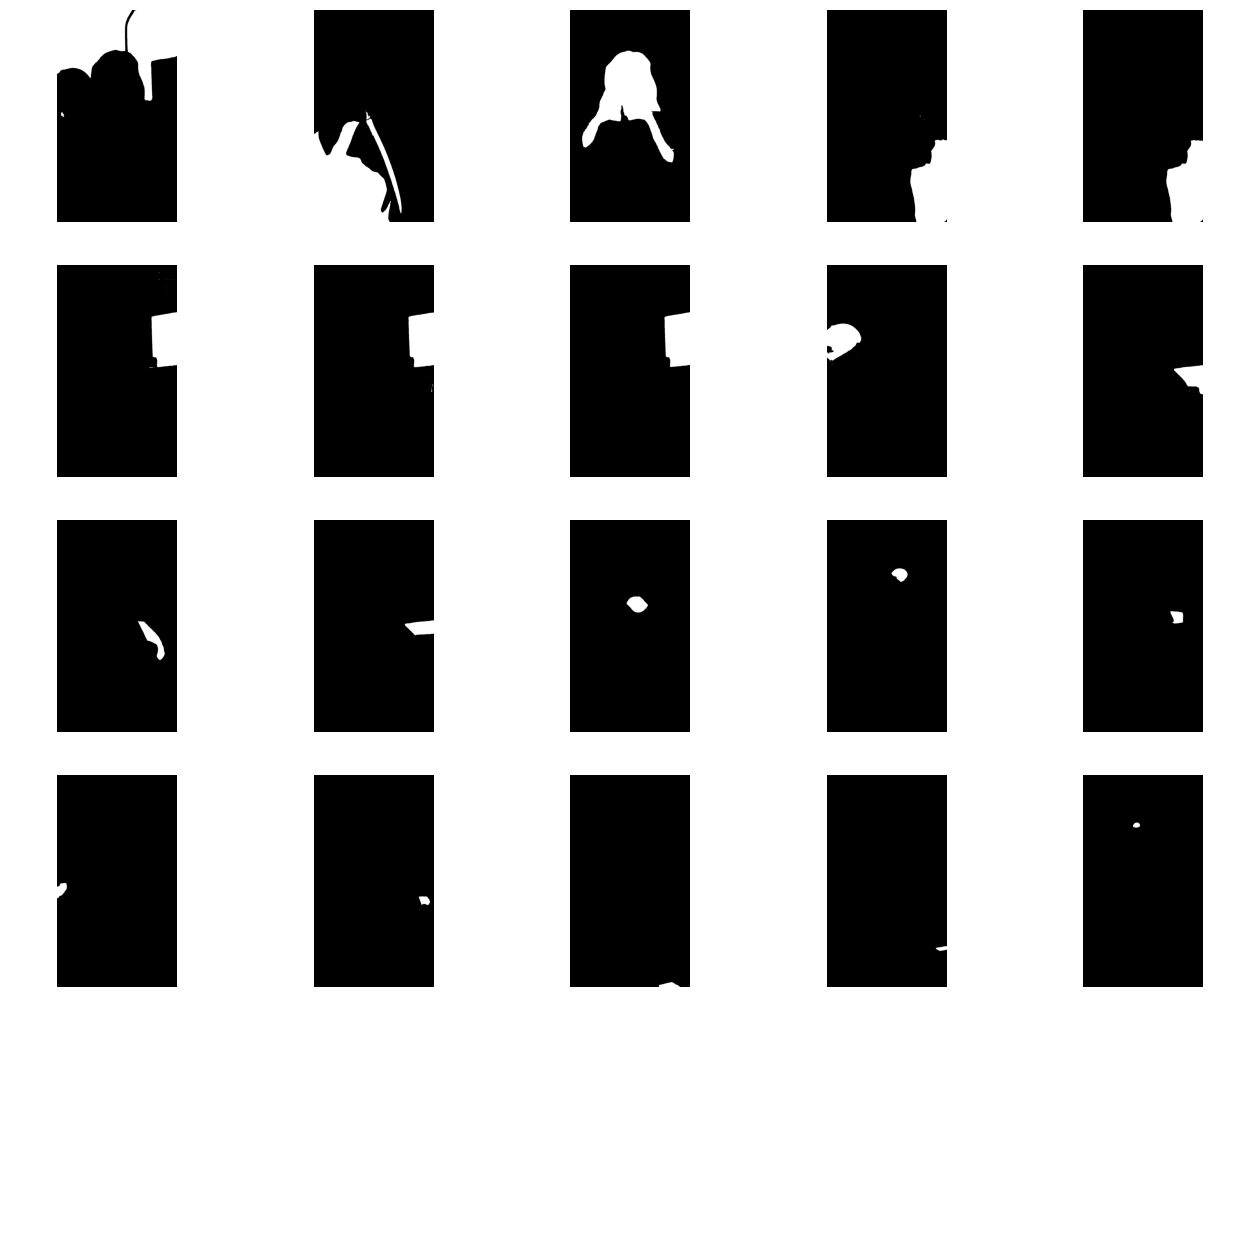

In [34]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:25],
    grid_size=(5, 5),
    size=(16, 16)
)

## Automatic mask generation options

In [35]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

**NOTE:** This may take a lot longer to compleate.

In [36]:
sam2_result2 = mask_generator_2.generate(image_rgb)

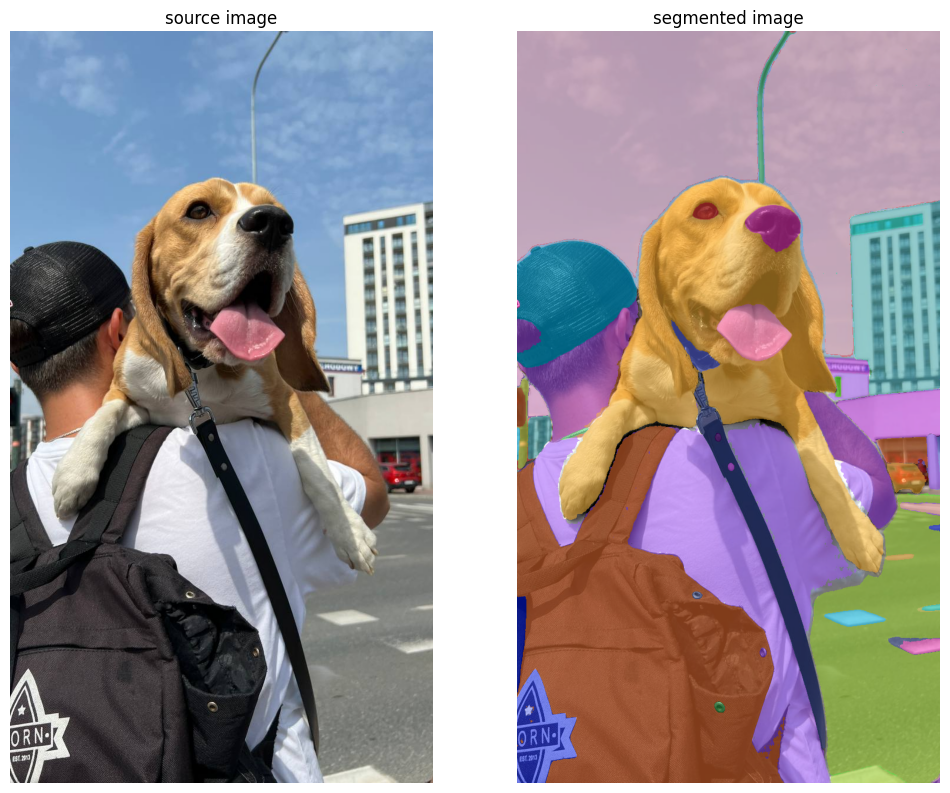

In [37]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam2_result2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Generate Segmentation with Bounding Box

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [38]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

predictor = SAM2ImagePredictor(sam2_model)

In [39]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box

In [41]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [42]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [54]:
widget.bboxes

[{'x': 383, 'y': 287, 'width': 105, 'height': 76, 'label': ''},
 {'x': 340, 'y': 456, 'width': 130, 'height': 106, 'label': ''},
 {'x': 72, 'y': 248, 'width': 552, 'height': 680, 'label': ''}]

### Generate masks with SAM

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [55]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = [{'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

In [64]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)
masks = np.squeeze(masks)

### Results visualisation with Supervision

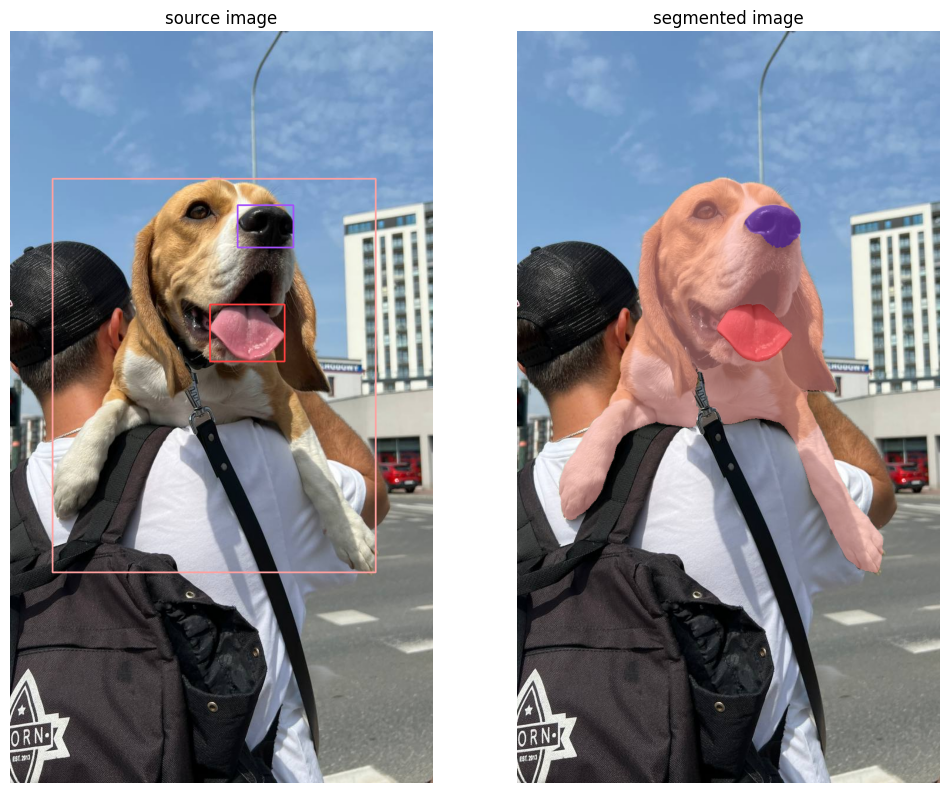

In [67]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)
# detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)